In [1]:
!wget https://datasets.simula.no/downloads/kvasir-seg.zip

--2023-02-12 12:25:37--  https://datasets.simula.no/downloads/kvasir-seg.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46227172 (44M) [application/zip]
Saving to: ‘kvasir-seg.zip’

kvasir-seg.zip      100%[===================>]  44.08M  9.28MB/s    in 5.2s    

2023-02-12 12:25:44 (8.51 MB/s) - ‘kvasir-seg.zip’ saved [46227172/46227172]



In [2]:
!unzip -qq kvasir-seg.zip

In [1]:
# import the necessary packages
import torch
import os
# base path of the dataset
DATASET_PATH = os.path.join("Kvasir-SEG")
# define the path to the images and masks dataset
IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "images")
MASK_DATASET_PATH = os.path.join(DATASET_PATH, "masks")
# define the test split
TEST_SPLIT = 0.15
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 200
BATCH_SIZE = 64
# define the input image dimensions
INPUT_IMAGE_WIDTH = 128
INPUT_IMAGE_HEIGHT = 128
# define threshold to filter weak predictions
THRESHOLD = 0.5
# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [3]:
# import the necessary packages
from torch.utils.data import Dataset
import cv2
class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms
	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		mask = cv2.imread(self.maskPaths[idx], 0)
		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)
		# return a tuple of the image and its mask
		return (image, mask)

In [4]:
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch

In [5]:
class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))

In [6]:
class Encoder(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs

In [7]:
class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures

In [8]:
class UNet(Module):
  def __init__(self, encChannels=(3, 16, 32, 64),
    decChannels=(64, 32, 16),
		nbClasses=1, retainDim=True,
		outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
      super().__init__()
      # initialize the encoder and decoder
      self.encoder = Encoder(encChannels)
      self.decoder = Decoder(decChannels)
      # initialize the regression head and store the class variables
      self.head = Conv2d(decChannels[-1], nbClasses, 1)
      self.retainDim = retainDim
      self.outSize = outSize
  def forward(self, x):
		# grab the features from the encoder
    encFeatures = self.encoder(x)
		# pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
    decFeatures = self.decoder(encFeatures[::-1][0],encFeatures[::-1][1:])
		# pass the decoder features through the regression head to
		# obtain the segmentation mask
    map = self.head(decFeatures)
		# check to see if we are retaining the original output
		# dimensions and if so, then resize the output to match them
    if self.retainDim:
      map = F.interpolate(map, self.outSize)
		# return the segmentation map
    return map

In [9]:
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os

In [10]:
imagePaths = sorted(list(paths.list_images(IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(MASK_DATASET_PATH)))
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths,
	test_size=TEST_SPLIT, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]
# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


In [11]:
PIN_MEMORY = True if DEVICE == "cuda" else False

In [12]:
# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((INPUT_IMAGE_HEIGHT,INPUT_IMAGE_WIDTH)),
	transforms.ToTensor()])
# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,
	transforms=transforms)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,
    transforms=transforms)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
	num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
	num_workers=os.cpu_count())

[INFO] found 850 examples in the training set...
[INFO] found 150 examples in the test set...


In [13]:
# initialize our UNet model
unet = UNet().to(DEVICE)
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=INIT_LR)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [14]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


  0%|          | 1/200 [00:09<30:27,  9.18s/it]

[INFO] EPOCH: 1/200
Train loss: 0.635178, Test loss: 0.7451


  1%|          | 2/200 [00:17<29:18,  8.88s/it]

[INFO] EPOCH: 2/200
Train loss: 0.499629, Test loss: 0.6649


  2%|▏         | 3/200 [00:26<29:28,  8.98s/it]

[INFO] EPOCH: 3/200
Train loss: 0.445941, Test loss: 0.6358


  2%|▏         | 4/200 [00:35<28:47,  8.81s/it]

[INFO] EPOCH: 4/200
Train loss: 0.433410, Test loss: 0.6153


  2%|▎         | 5/200 [00:43<28:04,  8.64s/it]

[INFO] EPOCH: 5/200
Train loss: 0.420011, Test loss: 0.6279


  3%|▎         | 6/200 [00:52<28:15,  8.74s/it]

[INFO] EPOCH: 6/200
Train loss: 0.415438, Test loss: 0.6071


  4%|▎         | 7/200 [01:00<27:18,  8.49s/it]

[INFO] EPOCH: 7/200
Train loss: 0.411956, Test loss: 0.6088


  4%|▍         | 8/200 [01:09<26:59,  8.44s/it]

[INFO] EPOCH: 8/200
Train loss: 0.408499, Test loss: 0.6077


  4%|▍         | 9/200 [01:18<27:30,  8.64s/it]

[INFO] EPOCH: 9/200
Train loss: 0.407737, Test loss: 0.6184


  5%|▌         | 10/200 [01:25<26:29,  8.37s/it]

[INFO] EPOCH: 10/200
Train loss: 0.417753, Test loss: 0.6079


  6%|▌         | 11/200 [01:34<26:27,  8.40s/it]

[INFO] EPOCH: 11/200
Train loss: 0.406476, Test loss: 0.6078


  6%|▌         | 12/200 [01:43<26:55,  8.60s/it]

[INFO] EPOCH: 12/200
Train loss: 0.404824, Test loss: 0.6368


  6%|▋         | 13/200 [01:51<25:56,  8.32s/it]

[INFO] EPOCH: 13/200
Train loss: 0.407572, Test loss: 0.6056


  7%|▋         | 14/200 [02:00<26:24,  8.52s/it]

[INFO] EPOCH: 14/200
Train loss: 0.403855, Test loss: 0.6079


  8%|▊         | 15/200 [02:09<26:37,  8.64s/it]

[INFO] EPOCH: 15/200
Train loss: 0.406571, Test loss: 0.6057


  8%|▊         | 16/200 [02:16<25:45,  8.40s/it]

[INFO] EPOCH: 16/200
Train loss: 0.404301, Test loss: 0.6081


  8%|▊         | 17/200 [02:25<25:57,  8.51s/it]

[INFO] EPOCH: 17/200
Train loss: 0.405481, Test loss: 0.6036


  9%|▉         | 18/200 [02:34<26:17,  8.67s/it]

[INFO] EPOCH: 18/200
Train loss: 0.414566, Test loss: 0.6095


 10%|▉         | 19/200 [02:42<25:07,  8.33s/it]

[INFO] EPOCH: 19/200
Train loss: 0.419553, Test loss: 0.5974


 10%|█         | 20/200 [02:51<25:27,  8.49s/it]

[INFO] EPOCH: 20/200
Train loss: 0.400978, Test loss: 0.5990


 10%|█         | 21/200 [02:59<25:40,  8.61s/it]

[INFO] EPOCH: 21/200
Train loss: 0.402070, Test loss: 0.6177


 11%|█         | 22/200 [03:07<24:49,  8.37s/it]

[INFO] EPOCH: 22/200
Train loss: 0.401030, Test loss: 0.5952


 12%|█▏        | 23/200 [03:16<25:19,  8.58s/it]

[INFO] EPOCH: 23/200
Train loss: 0.402029, Test loss: 0.5981


 12%|█▏        | 24/200 [03:25<25:39,  8.75s/it]

[INFO] EPOCH: 24/200
Train loss: 0.403006, Test loss: 0.5925


 12%|█▎        | 25/200 [03:33<24:46,  8.50s/it]

[INFO] EPOCH: 25/200
Train loss: 0.407126, Test loss: 0.5937


 13%|█▎        | 26/200 [03:42<24:48,  8.56s/it]

[INFO] EPOCH: 26/200
Train loss: 0.399930, Test loss: 0.5923


 14%|█▎        | 27/200 [03:51<25:08,  8.72s/it]

[INFO] EPOCH: 27/200
Train loss: 0.402069, Test loss: 0.5971


 14%|█▍        | 28/200 [03:59<24:28,  8.54s/it]

[INFO] EPOCH: 28/200
Train loss: 0.402044, Test loss: 0.5965


 14%|█▍        | 29/200 [04:08<24:28,  8.59s/it]

[INFO] EPOCH: 29/200
Train loss: 0.400157, Test loss: 0.5931


 15%|█▌        | 30/200 [04:17<24:53,  8.79s/it]

[INFO] EPOCH: 30/200
Train loss: 0.393497, Test loss: 0.6002


 16%|█▌        | 31/200 [04:26<24:28,  8.69s/it]

[INFO] EPOCH: 31/200
Train loss: 0.393497, Test loss: 0.5829


 16%|█▌        | 32/200 [04:34<24:08,  8.62s/it]

[INFO] EPOCH: 32/200
Train loss: 0.396495, Test loss: 0.5841


 16%|█▋        | 33/200 [04:43<24:22,  8.76s/it]

[INFO] EPOCH: 33/200
Train loss: 0.402820, Test loss: 0.5759


 17%|█▋        | 34/200 [04:52<23:50,  8.62s/it]

[INFO] EPOCH: 34/200
Train loss: 0.388154, Test loss: 0.5738


 18%|█▊        | 35/200 [05:00<23:18,  8.47s/it]

[INFO] EPOCH: 35/200
Train loss: 0.386524, Test loss: 0.5817


 18%|█▊        | 36/200 [05:09<23:38,  8.65s/it]

[INFO] EPOCH: 36/200
Train loss: 0.394034, Test loss: 0.5857


 18%|█▊        | 37/200 [05:17<23:23,  8.61s/it]

[INFO] EPOCH: 37/200
Train loss: 0.390300, Test loss: 0.5733


 19%|█▉        | 38/200 [05:26<23:00,  8.52s/it]

[INFO] EPOCH: 38/200
Train loss: 0.390191, Test loss: 0.5887


 20%|█▉        | 39/200 [05:35<23:20,  8.70s/it]

[INFO] EPOCH: 39/200
Train loss: 0.388946, Test loss: 0.5723


 20%|██        | 40/200 [05:43<23:08,  8.68s/it]

[INFO] EPOCH: 40/200
Train loss: 0.388531, Test loss: 0.5685


 20%|██        | 41/200 [05:51<22:24,  8.45s/it]

[INFO] EPOCH: 41/200
Train loss: 0.382435, Test loss: 0.5914


 21%|██        | 42/200 [06:01<23:09,  8.79s/it]

[INFO] EPOCH: 42/200
Train loss: 0.389285, Test loss: 0.5710


 22%|██▏       | 43/200 [06:09<22:39,  8.66s/it]

[INFO] EPOCH: 43/200
Train loss: 0.384206, Test loss: 0.5596


 22%|██▏       | 44/200 [06:18<22:27,  8.64s/it]

[INFO] EPOCH: 44/200
Train loss: 0.385685, Test loss: 0.5762


 22%|██▎       | 45/200 [06:27<22:38,  8.76s/it]

[INFO] EPOCH: 45/200
Train loss: 0.384956, Test loss: 0.5594


 23%|██▎       | 46/200 [06:35<22:24,  8.73s/it]

[INFO] EPOCH: 46/200
Train loss: 0.383161, Test loss: 0.5546


 24%|██▎       | 47/200 [06:44<21:55,  8.60s/it]

[INFO] EPOCH: 47/200
Train loss: 0.378095, Test loss: 0.5653


 24%|██▍       | 48/200 [06:53<22:04,  8.72s/it]

[INFO] EPOCH: 48/200
Train loss: 0.384106, Test loss: 0.5547


 24%|██▍       | 49/200 [07:02<22:06,  8.78s/it]

[INFO] EPOCH: 49/200
Train loss: 0.381706, Test loss: 0.5538


 25%|██▌       | 50/200 [07:09<21:07,  8.45s/it]

[INFO] EPOCH: 50/200
Train loss: 0.377860, Test loss: 0.5532


 26%|██▌       | 51/200 [07:19<21:31,  8.67s/it]

[INFO] EPOCH: 51/200
Train loss: 0.370411, Test loss: 0.5416


 26%|██▌       | 52/200 [07:27<21:32,  8.73s/it]

[INFO] EPOCH: 52/200
Train loss: 0.370857, Test loss: 0.5386


 26%|██▋       | 53/200 [07:35<20:38,  8.42s/it]

[INFO] EPOCH: 53/200
Train loss: 0.369216, Test loss: 0.5482


 27%|██▋       | 54/200 [07:44<20:55,  8.60s/it]

[INFO] EPOCH: 54/200
Train loss: 0.375838, Test loss: 0.5567


 28%|██▊       | 55/200 [07:53<20:58,  8.68s/it]

[INFO] EPOCH: 55/200
Train loss: 0.379020, Test loss: 0.5568


 28%|██▊       | 56/200 [08:01<20:04,  8.37s/it]

[INFO] EPOCH: 56/200
Train loss: 0.370844, Test loss: 0.5440


 28%|██▊       | 57/200 [08:10<20:29,  8.60s/it]

[INFO] EPOCH: 57/200
Train loss: 0.366759, Test loss: 0.5369


 29%|██▉       | 58/200 [08:19<20:32,  8.68s/it]

[INFO] EPOCH: 58/200
Train loss: 0.362189, Test loss: 0.5310


 30%|██▉       | 59/200 [08:26<19:46,  8.41s/it]

[INFO] EPOCH: 59/200
Train loss: 0.361387, Test loss: 0.5356


 30%|███       | 60/200 [08:36<20:05,  8.61s/it]

[INFO] EPOCH: 60/200
Train loss: 0.365291, Test loss: 0.5368


 30%|███       | 61/200 [08:44<20:09,  8.70s/it]

[INFO] EPOCH: 61/200
Train loss: 0.369889, Test loss: 0.5357


 31%|███       | 62/200 [08:52<19:15,  8.37s/it]

[INFO] EPOCH: 62/200
Train loss: 0.365498, Test loss: 0.5314


 32%|███▏      | 63/200 [09:01<19:34,  8.57s/it]

[INFO] EPOCH: 63/200
Train loss: 0.360089, Test loss: 0.5213


 32%|███▏      | 64/200 [09:13<21:46,  9.61s/it]

[INFO] EPOCH: 64/200
Train loss: 0.359085, Test loss: 0.5344


 32%|███▎      | 65/200 [09:23<22:07,  9.83s/it]

[INFO] EPOCH: 65/200
Train loss: 0.359493, Test loss: 0.5375


 33%|███▎      | 66/200 [09:31<20:34,  9.21s/it]

[INFO] EPOCH: 66/200
Train loss: 0.359767, Test loss: 0.5241


 34%|███▎      | 67/200 [09:40<20:15,  9.14s/it]

[INFO] EPOCH: 67/200
Train loss: 0.358166, Test loss: 0.5310


 34%|███▍      | 68/200 [09:49<19:51,  9.03s/it]

[INFO] EPOCH: 68/200
Train loss: 0.350288, Test loss: 0.5204


 34%|███▍      | 69/200 [09:57<18:51,  8.64s/it]

[INFO] EPOCH: 69/200
Train loss: 0.361881, Test loss: 0.5210


 35%|███▌      | 70/200 [10:06<18:58,  8.75s/it]

[INFO] EPOCH: 70/200
Train loss: 0.354150, Test loss: 0.5180


 36%|███▌      | 71/200 [10:15<18:53,  8.79s/it]

[INFO] EPOCH: 71/200
Train loss: 0.354802, Test loss: 0.5185


 36%|███▌      | 72/200 [10:22<18:04,  8.47s/it]

[INFO] EPOCH: 72/200
Train loss: 0.353474, Test loss: 0.5187


 36%|███▋      | 73/200 [10:32<18:57,  8.95s/it]

[INFO] EPOCH: 73/200
Train loss: 0.347383, Test loss: 0.5123


 37%|███▋      | 74/200 [10:41<18:51,  8.98s/it]

[INFO] EPOCH: 74/200
Train loss: 0.351965, Test loss: 0.5243


 38%|███▊      | 75/200 [10:49<17:51,  8.57s/it]

[INFO] EPOCH: 75/200
Train loss: 0.345848, Test loss: 0.5138


 38%|███▊      | 76/200 [10:58<17:57,  8.69s/it]

[INFO] EPOCH: 76/200
Train loss: 0.342487, Test loss: 0.5137


 38%|███▊      | 77/200 [11:07<18:00,  8.79s/it]

[INFO] EPOCH: 77/200
Train loss: 0.339261, Test loss: 0.5106


 39%|███▉      | 78/200 [11:15<17:16,  8.49s/it]

[INFO] EPOCH: 78/200
Train loss: 0.350090, Test loss: 0.5136


 40%|███▉      | 79/200 [11:24<17:26,  8.65s/it]

[INFO] EPOCH: 79/200
Train loss: 0.351544, Test loss: 0.5132


 40%|████      | 80/200 [11:33<17:29,  8.74s/it]

[INFO] EPOCH: 80/200
Train loss: 0.337724, Test loss: 0.5173


 40%|████      | 81/200 [11:40<16:40,  8.41s/it]

[INFO] EPOCH: 81/200
Train loss: 0.340968, Test loss: 0.5102


 41%|████      | 82/200 [11:49<16:49,  8.56s/it]

[INFO] EPOCH: 82/200
Train loss: 0.340505, Test loss: 0.5050


 42%|████▏     | 83/200 [11:58<16:51,  8.65s/it]

[INFO] EPOCH: 83/200
Train loss: 0.350856, Test loss: 0.5006


 42%|████▏     | 84/200 [12:06<16:11,  8.37s/it]

[INFO] EPOCH: 84/200
Train loss: 0.348083, Test loss: 0.5128


 42%|████▎     | 85/200 [12:15<16:25,  8.57s/it]

[INFO] EPOCH: 85/200
Train loss: 0.338119, Test loss: 0.5123


 43%|████▎     | 86/200 [12:24<16:32,  8.70s/it]

[INFO] EPOCH: 86/200
Train loss: 0.340558, Test loss: 0.5048


 44%|████▎     | 87/200 [12:32<15:52,  8.43s/it]

[INFO] EPOCH: 87/200
Train loss: 0.344023, Test loss: 0.5046


 44%|████▍     | 88/200 [12:41<16:04,  8.61s/it]

[INFO] EPOCH: 88/200
Train loss: 0.331351, Test loss: 0.5092


 44%|████▍     | 89/200 [12:50<16:08,  8.73s/it]

[INFO] EPOCH: 89/200
Train loss: 0.329457, Test loss: 0.5142


 45%|████▌     | 90/200 [12:58<15:28,  8.44s/it]

[INFO] EPOCH: 90/200
Train loss: 0.329139, Test loss: 0.5019


 46%|████▌     | 91/200 [13:07<15:43,  8.65s/it]

[INFO] EPOCH: 91/200
Train loss: 0.327213, Test loss: 0.5067


 46%|████▌     | 92/200 [13:16<15:46,  8.77s/it]

[INFO] EPOCH: 92/200
Train loss: 0.327353, Test loss: 0.4937


 46%|████▋     | 93/200 [13:24<15:10,  8.51s/it]

[INFO] EPOCH: 93/200
Train loss: 0.321116, Test loss: 0.4909


 47%|████▋     | 94/200 [13:33<15:20,  8.68s/it]

[INFO] EPOCH: 94/200
Train loss: 0.326586, Test loss: 0.4976


 48%|████▊     | 95/200 [13:42<15:25,  8.82s/it]

[INFO] EPOCH: 95/200
Train loss: 0.325330, Test loss: 0.4915


 48%|████▊     | 96/200 [13:50<14:43,  8.50s/it]

[INFO] EPOCH: 96/200
Train loss: 0.325003, Test loss: 0.4944


 48%|████▊     | 97/200 [13:59<14:57,  8.71s/it]

[INFO] EPOCH: 97/200
Train loss: 0.319401, Test loss: 0.4896


 49%|████▉     | 98/200 [14:08<15:01,  8.84s/it]

[INFO] EPOCH: 98/200
Train loss: 0.322713, Test loss: 0.5004


 50%|████▉     | 99/200 [14:16<14:18,  8.50s/it]

[INFO] EPOCH: 99/200
Train loss: 0.315777, Test loss: 0.4945


 50%|█████     | 100/200 [14:25<14:25,  8.66s/it]

[INFO] EPOCH: 100/200
Train loss: 0.322287, Test loss: 0.4884


 50%|█████     | 101/200 [14:34<14:31,  8.81s/it]

[INFO] EPOCH: 101/200
Train loss: 0.315168, Test loss: 0.4883


 51%|█████     | 102/200 [14:42<13:52,  8.50s/it]

[INFO] EPOCH: 102/200
Train loss: 0.314053, Test loss: 0.4909


 52%|█████▏    | 103/200 [14:51<13:57,  8.64s/it]

[INFO] EPOCH: 103/200
Train loss: 0.319143, Test loss: 0.5027


 52%|█████▏    | 104/200 [15:00<14:06,  8.82s/it]

[INFO] EPOCH: 104/200
Train loss: 0.309785, Test loss: 0.4830


 52%|█████▎    | 105/200 [15:08<13:33,  8.57s/it]

[INFO] EPOCH: 105/200
Train loss: 0.313458, Test loss: 0.4854


 53%|█████▎    | 106/200 [15:17<13:34,  8.66s/it]

[INFO] EPOCH: 106/200
Train loss: 0.311028, Test loss: 0.4881


 54%|█████▎    | 107/200 [15:26<13:42,  8.84s/it]

[INFO] EPOCH: 107/200
Train loss: 0.312373, Test loss: 0.4839


 54%|█████▍    | 108/200 [15:34<13:13,  8.62s/it]

[INFO] EPOCH: 108/200
Train loss: 0.310484, Test loss: 0.4831


 55%|█████▍    | 109/200 [15:43<13:05,  8.63s/it]

[INFO] EPOCH: 109/200
Train loss: 0.313448, Test loss: 0.4856


 55%|█████▌    | 110/200 [15:52<13:09,  8.77s/it]

[INFO] EPOCH: 110/200
Train loss: 0.307993, Test loss: 0.4991


 56%|█████▌    | 111/200 [16:00<12:54,  8.70s/it]

[INFO] EPOCH: 111/200
Train loss: 0.313835, Test loss: 0.4879


 56%|█████▌    | 112/200 [16:09<12:34,  8.58s/it]

[INFO] EPOCH: 112/200
Train loss: 0.310332, Test loss: 0.4977


 56%|█████▋    | 113/200 [16:18<12:39,  8.73s/it]

[INFO] EPOCH: 113/200
Train loss: 0.310096, Test loss: 0.4813


 57%|█████▋    | 114/200 [16:27<12:39,  8.83s/it]

[INFO] EPOCH: 114/200
Train loss: 0.308565, Test loss: 0.4769


 57%|█████▊    | 115/200 [16:35<12:11,  8.60s/it]

[INFO] EPOCH: 115/200
Train loss: 0.310142, Test loss: 0.4948


 58%|█████▊    | 116/200 [16:44<12:14,  8.74s/it]

[INFO] EPOCH: 116/200
Train loss: 0.303068, Test loss: 0.4848


 58%|█████▊    | 117/200 [16:53<12:06,  8.76s/it]

[INFO] EPOCH: 117/200
Train loss: 0.303132, Test loss: 0.4786


 59%|█████▉    | 118/200 [17:01<11:36,  8.49s/it]

[INFO] EPOCH: 118/200
Train loss: 0.300272, Test loss: 0.4862


 60%|█████▉    | 119/200 [17:10<11:42,  8.67s/it]

[INFO] EPOCH: 119/200
Train loss: 0.297274, Test loss: 0.4845


 60%|██████    | 120/200 [17:19<11:39,  8.74s/it]

[INFO] EPOCH: 120/200
Train loss: 0.295273, Test loss: 0.5361


 60%|██████    | 121/200 [17:26<11:09,  8.47s/it]

[INFO] EPOCH: 121/200
Train loss: 0.311430, Test loss: 0.4884


 61%|██████    | 122/200 [17:36<11:16,  8.68s/it]

[INFO] EPOCH: 122/200
Train loss: 0.311689, Test loss: 0.4957


 62%|██████▏   | 123/200 [17:44<11:11,  8.73s/it]

[INFO] EPOCH: 123/200
Train loss: 0.305702, Test loss: 0.4840


 62%|██████▏   | 124/200 [17:52<10:41,  8.44s/it]

[INFO] EPOCH: 124/200
Train loss: 0.296175, Test loss: 0.4767


 62%|██████▎   | 125/200 [18:01<10:50,  8.67s/it]

[INFO] EPOCH: 125/200
Train loss: 0.296998, Test loss: 0.4768


 63%|██████▎   | 126/200 [18:10<10:44,  8.71s/it]

[INFO] EPOCH: 126/200
Train loss: 0.297044, Test loss: 0.4892


 64%|██████▎   | 127/200 [18:18<10:12,  8.39s/it]

[INFO] EPOCH: 127/200
Train loss: 0.293435, Test loss: 0.4849


 64%|██████▍   | 128/200 [18:27<10:17,  8.58s/it]

[INFO] EPOCH: 128/200
Train loss: 0.291404, Test loss: 0.4680


 64%|██████▍   | 129/200 [18:36<10:15,  8.68s/it]

[INFO] EPOCH: 129/200
Train loss: 0.288019, Test loss: 0.4842


 65%|██████▌   | 130/200 [18:43<09:45,  8.37s/it]

[INFO] EPOCH: 130/200
Train loss: 0.295126, Test loss: 0.4881


 66%|██████▌   | 131/200 [18:52<09:50,  8.55s/it]

[INFO] EPOCH: 131/200
Train loss: 0.298222, Test loss: 0.4979


 66%|██████▌   | 132/200 [19:01<09:49,  8.66s/it]

[INFO] EPOCH: 132/200
Train loss: 0.295042, Test loss: 0.4768


 66%|██████▋   | 133/200 [19:09<09:21,  8.38s/it]

[INFO] EPOCH: 133/200
Train loss: 0.288972, Test loss: 0.4859


 67%|██████▋   | 134/200 [19:18<09:27,  8.60s/it]

[INFO] EPOCH: 134/200
Train loss: 0.283347, Test loss: 0.5060


 68%|██████▊   | 135/200 [19:27<09:21,  8.63s/it]

[INFO] EPOCH: 135/200
Train loss: 0.295833, Test loss: 0.4963


 68%|██████▊   | 136/200 [19:35<08:59,  8.44s/it]

[INFO] EPOCH: 136/200
Train loss: 0.289154, Test loss: 0.4869


 68%|██████▊   | 137/200 [19:44<09:01,  8.59s/it]

[INFO] EPOCH: 137/200
Train loss: 0.282187, Test loss: 0.4734


 69%|██████▉   | 138/200 [19:53<08:54,  8.63s/it]

[INFO] EPOCH: 138/200
Train loss: 0.284388, Test loss: 0.4761


 70%|██████▉   | 139/200 [20:00<08:27,  8.33s/it]

[INFO] EPOCH: 139/200
Train loss: 0.286614, Test loss: 0.4722


 70%|███████   | 140/200 [20:09<08:32,  8.54s/it]

[INFO] EPOCH: 140/200
Train loss: 0.285865, Test loss: 0.4867


 70%|███████   | 141/200 [20:18<08:25,  8.56s/it]

[INFO] EPOCH: 141/200
Train loss: 0.285729, Test loss: 0.4758


 71%|███████   | 142/200 [20:26<08:09,  8.43s/it]

[INFO] EPOCH: 142/200
Train loss: 0.280768, Test loss: 0.4707


 72%|███████▏  | 143/200 [20:35<08:12,  8.64s/it]

[INFO] EPOCH: 143/200
Train loss: 0.275951, Test loss: 0.4745


 72%|███████▏  | 144/200 [20:44<08:03,  8.63s/it]

[INFO] EPOCH: 144/200
Train loss: 0.274768, Test loss: 0.5041


 72%|███████▎  | 145/200 [20:52<07:45,  8.46s/it]

[INFO] EPOCH: 145/200
Train loss: 0.274599, Test loss: 0.4827


 73%|███████▎  | 146/200 [21:01<07:47,  8.65s/it]

[INFO] EPOCH: 146/200
Train loss: 0.267622, Test loss: 0.4848


 74%|███████▎  | 147/200 [21:09<07:35,  8.60s/it]

[INFO] EPOCH: 147/200
Train loss: 0.269405, Test loss: 0.4733


 74%|███████▍  | 148/200 [21:18<07:21,  8.50s/it]

[INFO] EPOCH: 148/200
Train loss: 0.272816, Test loss: 0.4813


 74%|███████▍  | 149/200 [21:27<07:21,  8.66s/it]

[INFO] EPOCH: 149/200
Train loss: 0.270290, Test loss: 0.5142


 75%|███████▌  | 150/200 [21:36<07:20,  8.82s/it]

[INFO] EPOCH: 150/200
Train loss: 0.269183, Test loss: 0.4922


 76%|███████▌  | 151/200 [21:44<06:56,  8.50s/it]

[INFO] EPOCH: 151/200
Train loss: 0.263756, Test loss: 0.4866


 76%|███████▌  | 152/200 [21:53<06:55,  8.66s/it]

[INFO] EPOCH: 152/200
Train loss: 0.271121, Test loss: 0.5207


 76%|███████▋  | 153/200 [22:01<06:47,  8.66s/it]

[INFO] EPOCH: 153/200
Train loss: 0.265278, Test loss: 0.5012


 77%|███████▋  | 154/200 [22:09<06:28,  8.46s/it]

[INFO] EPOCH: 154/200
Train loss: 0.258316, Test loss: 0.4906


 78%|███████▊  | 155/200 [22:18<06:26,  8.60s/it]

[INFO] EPOCH: 155/200
Train loss: 0.261909, Test loss: 0.4832


 78%|███████▊  | 156/200 [22:27<06:15,  8.54s/it]

[INFO] EPOCH: 156/200
Train loss: 0.276233, Test loss: 0.5079


 78%|███████▊  | 157/200 [22:35<06:05,  8.50s/it]

[INFO] EPOCH: 157/200
Train loss: 0.265697, Test loss: 0.4840


 79%|███████▉  | 158/200 [22:44<06:02,  8.64s/it]

[INFO] EPOCH: 158/200
Train loss: 0.260651, Test loss: 0.4897


 80%|███████▉  | 159/200 [22:52<05:52,  8.60s/it]

[INFO] EPOCH: 159/200
Train loss: 0.263003, Test loss: 0.4782


 80%|████████  | 160/200 [23:01<05:37,  8.45s/it]

[INFO] EPOCH: 160/200
Train loss: 0.254212, Test loss: 0.5002


 80%|████████  | 161/200 [23:10<05:37,  8.65s/it]

[INFO] EPOCH: 161/200
Train loss: 0.251494, Test loss: 0.5008


 81%|████████  | 162/200 [23:18<05:24,  8.53s/it]

[INFO] EPOCH: 162/200
Train loss: 0.250810, Test loss: 0.5028


 82%|████████▏ | 163/200 [23:26<05:14,  8.50s/it]

[INFO] EPOCH: 163/200
Train loss: 0.247746, Test loss: 0.5375


 82%|████████▏ | 164/200 [23:35<05:13,  8.70s/it]

[INFO] EPOCH: 164/200
Train loss: 0.250001, Test loss: 0.5029


 82%|████████▎ | 165/200 [23:44<04:58,  8.54s/it]

[INFO] EPOCH: 165/200
Train loss: 0.244956, Test loss: 0.5140


 83%|████████▎ | 166/200 [23:52<04:46,  8.44s/it]

[INFO] EPOCH: 166/200
Train loss: 0.246846, Test loss: 0.4914


 84%|████████▎ | 167/200 [24:01<04:43,  8.61s/it]

[INFO] EPOCH: 167/200
Train loss: 0.246699, Test loss: 0.5114


 84%|████████▍ | 168/200 [24:09<04:32,  8.52s/it]

[INFO] EPOCH: 168/200
Train loss: 0.243251, Test loss: 0.4904


 84%|████████▍ | 169/200 [24:18<04:22,  8.47s/it]

[INFO] EPOCH: 169/200
Train loss: 0.248537, Test loss: 0.4988


 85%|████████▌ | 170/200 [24:27<04:18,  8.62s/it]

[INFO] EPOCH: 170/200
Train loss: 0.248666, Test loss: 0.5035


 86%|████████▌ | 171/200 [24:35<04:04,  8.45s/it]

[INFO] EPOCH: 171/200
Train loss: 0.245894, Test loss: 0.5001


 86%|████████▌ | 172/200 [24:43<03:57,  8.49s/it]

[INFO] EPOCH: 172/200
Train loss: 0.244000, Test loss: 0.4964


 86%|████████▋ | 173/200 [24:52<03:53,  8.65s/it]

[INFO] EPOCH: 173/200
Train loss: 0.248734, Test loss: 0.4864


 87%|████████▋ | 174/200 [25:00<03:41,  8.53s/it]

[INFO] EPOCH: 174/200
Train loss: 0.240695, Test loss: 0.5110


 88%|████████▊ | 175/200 [25:09<03:32,  8.50s/it]

[INFO] EPOCH: 175/200
Train loss: 0.242683, Test loss: 0.5230


 88%|████████▊ | 176/200 [25:18<03:27,  8.64s/it]

[INFO] EPOCH: 176/200
Train loss: 0.246010, Test loss: 0.5030


 88%|████████▊ | 177/200 [25:26<03:14,  8.46s/it]

[INFO] EPOCH: 177/200
Train loss: 0.231786, Test loss: 0.4994


 89%|████████▉ | 178/200 [25:34<03:05,  8.45s/it]

[INFO] EPOCH: 178/200
Train loss: 0.230920, Test loss: 0.5527


 90%|████████▉ | 179/200 [25:43<03:00,  8.58s/it]

[INFO] EPOCH: 179/200
Train loss: 0.237982, Test loss: 0.5008


 90%|█████████ | 180/200 [25:51<02:49,  8.46s/it]

[INFO] EPOCH: 180/200
Train loss: 0.229456, Test loss: 0.5218


 90%|█████████ | 181/200 [26:00<02:41,  8.48s/it]

[INFO] EPOCH: 181/200
Train loss: 0.230774, Test loss: 0.5076


 91%|█████████ | 182/200 [26:09<02:36,  8.69s/it]

[INFO] EPOCH: 182/200
Train loss: 0.224090, Test loss: 0.5457


 92%|█████████▏| 183/200 [26:17<02:24,  8.51s/it]

[INFO] EPOCH: 183/200
Train loss: 0.221423, Test loss: 0.5342


 92%|█████████▏| 184/200 [26:26<02:16,  8.51s/it]

[INFO] EPOCH: 184/200
Train loss: 0.223090, Test loss: 0.5208


 92%|█████████▎| 185/200 [26:35<02:09,  8.66s/it]

[INFO] EPOCH: 185/200
Train loss: 0.220382, Test loss: 0.5430


 93%|█████████▎| 186/200 [26:43<01:58,  8.45s/it]

[INFO] EPOCH: 186/200
Train loss: 0.231957, Test loss: 0.5066


 94%|█████████▎| 187/200 [26:51<01:50,  8.49s/it]

[INFO] EPOCH: 187/200
Train loss: 0.220703, Test loss: 0.5579


 94%|█████████▍| 188/200 [27:00<01:43,  8.63s/it]

[INFO] EPOCH: 188/200
Train loss: 0.227520, Test loss: 0.5158


 94%|█████████▍| 189/200 [27:08<01:32,  8.38s/it]

[INFO] EPOCH: 189/200
Train loss: 0.222138, Test loss: 0.5187


 95%|█████████▌| 190/200 [27:17<01:26,  8.62s/it]

[INFO] EPOCH: 190/200
Train loss: 0.218956, Test loss: 0.5131


 96%|█████████▌| 191/200 [27:26<01:18,  8.76s/it]

[INFO] EPOCH: 191/200
Train loss: 0.224139, Test loss: 0.5261


 96%|█████████▌| 192/200 [27:34<01:07,  8.47s/it]

[INFO] EPOCH: 192/200
Train loss: 0.221098, Test loss: 0.5415


 96%|█████████▋| 193/200 [27:43<01:00,  8.68s/it]

[INFO] EPOCH: 193/200
Train loss: 0.214746, Test loss: 0.5349


 97%|█████████▋| 194/200 [27:52<00:52,  8.79s/it]

[INFO] EPOCH: 194/200
Train loss: 0.208370, Test loss: 0.5632


 98%|█████████▊| 195/200 [28:00<00:42,  8.52s/it]

[INFO] EPOCH: 195/200
Train loss: 0.210744, Test loss: 0.5231


 98%|█████████▊| 196/200 [28:09<00:34,  8.57s/it]

[INFO] EPOCH: 196/200
Train loss: 0.212749, Test loss: 0.5838


 98%|█████████▊| 197/200 [28:18<00:26,  8.74s/it]

[INFO] EPOCH: 197/200
Train loss: 0.224518, Test loss: 0.5246


 99%|█████████▉| 198/200 [28:26<00:16,  8.46s/it]

[INFO] EPOCH: 198/200
Train loss: 0.215247, Test loss: 0.5642


100%|█████████▉| 199/200 [28:34<00:08,  8.55s/it]

[INFO] EPOCH: 199/200
Train loss: 0.211473, Test loss: 0.5432


100%|██████████| 200/200 [28:44<00:00,  8.62s/it]

[INFO] EPOCH: 200/200
Train loss: 0.202668, Test loss: 0.5895
[INFO] total time taken to train the model: 1724.04s


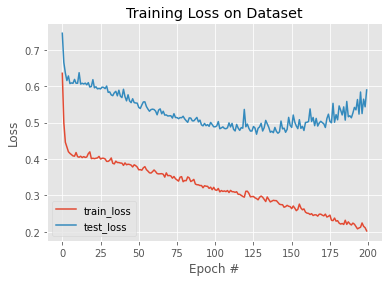

In [15]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
# serialize the model to disk
torch.save(unet, MODEL_PATH)

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

In [17]:
def make_predictions(model, imagePath):
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image.astype("float32") / 255.0
		# resize the image and make a copy of it for visualization
		image = cv2.resize(image, (128, 128))
		orig = image.copy()
		# find the filename and generate the path to ground truth
		# mask
		filename = imagePath.split(os.path.sep)[-1]
		groundTruthPath = os.path.join(MASK_DATASET_PATH,
			filename)
		# load the ground-truth segmentation mask in grayscale mode
		# and resize it
		gtMask = cv2.imread(groundTruthPath, 0)
		gtMask = cv2.resize(gtMask, (INPUT_IMAGE_HEIGHT, INPUT_IMAGE_HEIGHT))
    # make the channel axis to be the leading one, add a batch
		# dimension, create a PyTorch tensor, and flash it to the
		# current device
		image = np.transpose(image, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image = torch.from_numpy(image).to(DEVICE)
		# make the prediction, pass the results through the sigmoid
		# function, and convert the result to a NumPy array
		predMask = model(image).squeeze()
		predMask = torch.sigmoid(predMask)
		predMask = predMask.cpu().numpy()
		# filter out the weak predictions and convert them to integers
		predMask = (predMask > THRESHOLD) * 255
		predMask = predMask.astype(np.uint8)
		# prepare a plot for visualization
		prepare_plot(orig, gtMask, predMask)

[INFO] loading up test image paths...
[INFO] load up model...


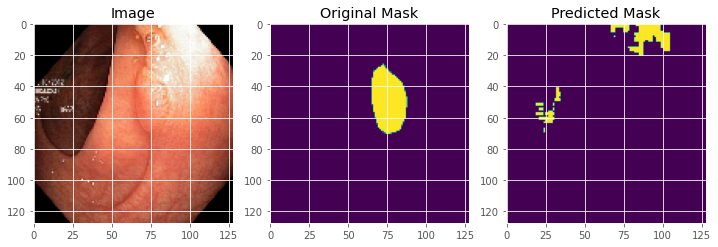

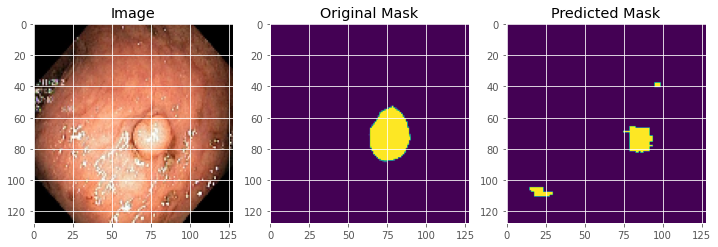

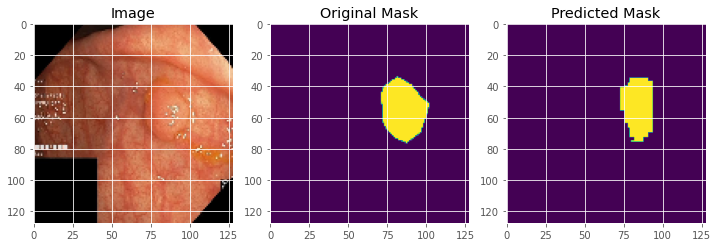

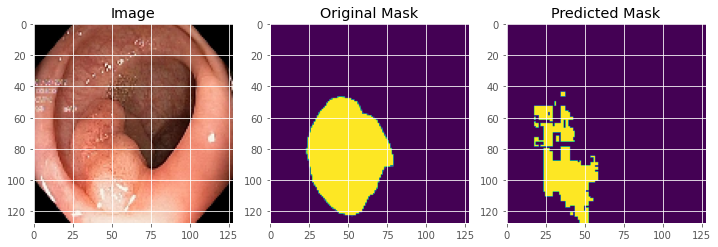

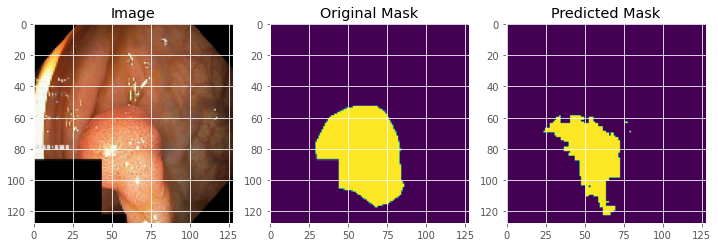

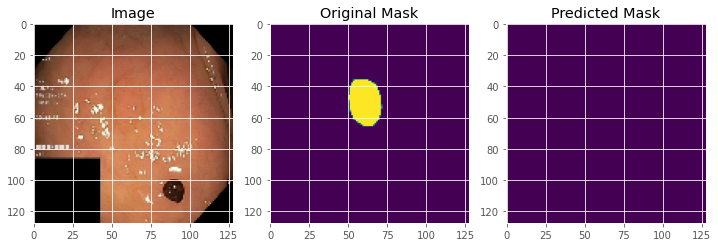

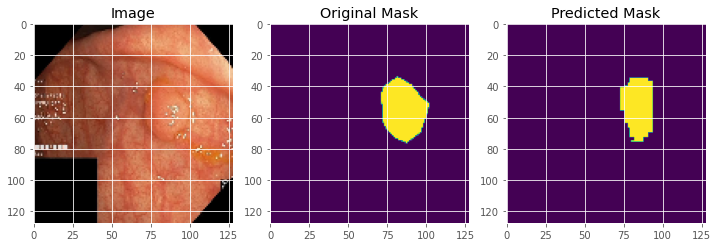

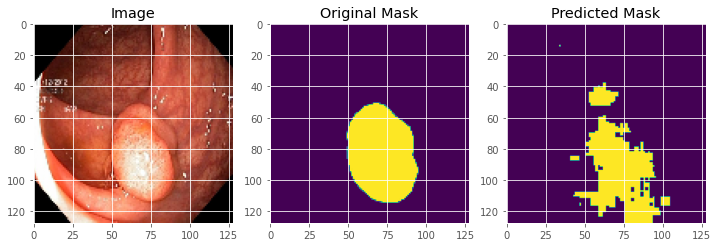

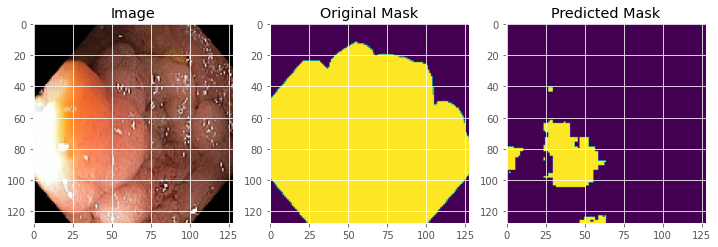

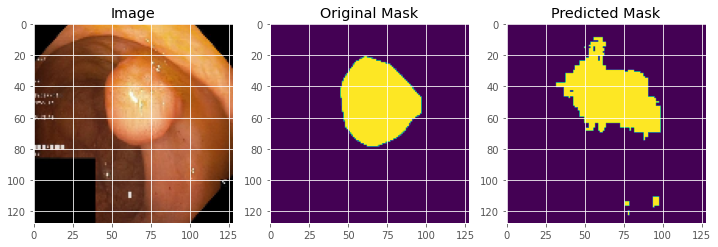

In [18]:
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
imagePaths = open(TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(MODEL_PATH).to(DEVICE)
# iterate over the randomly selected test image paths
for path in imagePaths:
	# make predictions and visualize the results
	make_predictions(unet, path)